### Statistiek
Hier vind je de algemene verwerking van de data

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, chisquare
import numpy as np


In [55]:
### data inladen
wedstrijden = pd.read_excel('../../Data/Silver/wedstrijden_controlled.xlsx')
corners = pd.read_excel('../../Data/Silver/cornerballen_controlled.xlsx')

merged_df = pd.merge(wedstrijden, corners, on='wedstrijd_id', how='left')



<Axes: title={'center': 'Aantal wedstrijden per niveau'}, xlabel='Niveau', ylabel='Aantal wedstrijden'>

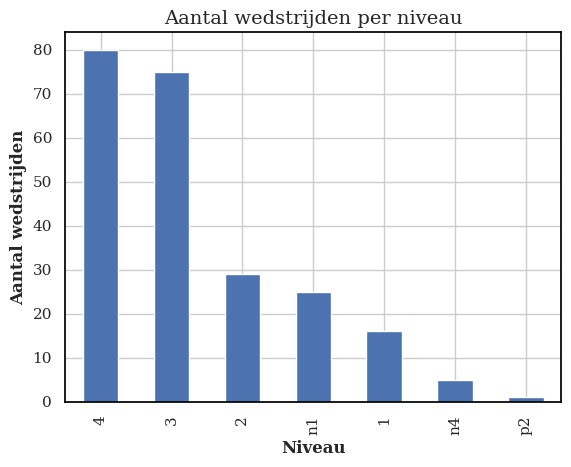

In [56]:
# distributie van de wedstrijden per niveau

wedstrijden["niveau"].value_counts().plot(kind='bar', title='Aantal wedstrijden per niveau', xlabel='Niveau', ylabel='Aantal wedstrijden')


### scorepercentages

In [57]:
def calculate_distribution_by_column(df, column_name):
    """
    Functie om het aantal schepcorners per unieke waarde van een opgegeven kolom te berekenen,
    evenals het scorepercentage (aantal gescoorde schepcorners / aantal schepcorners).
    
    Parameters:
    - df: DataFrame met de data
    - column_name: naam van de kolom waarvoor de verdeling berekend moet worden
    
    Returns:
    - DataFrame met de kolommen voor de opgegeven 'column_name', 'aantal_schepcorners', 'aantal_gescoord', 'scorepercentage'
    """
    # Aantal schepcorners per waarde van de opgegeven kolom
    aantal_schepcorners_per_value = df[column_name].value_counts()

    # Aantal gescoorde schepcorners per waarde van de opgegeven kolom
    aantal_gescoord_per_value = df.groupby(column_name)["goal"].sum()

    # DataFrame met de verdeling
    distributie_df = pd.DataFrame({
        "aantal_schepcorners": aantal_schepcorners_per_value,
        "aantal_gescoord": aantal_gescoord_per_value,
        "scorepercentage": aantal_gescoord_per_value / aantal_schepcorners_per_value * 100
    }).reset_index()
        
    return distributie_df

In [58]:
### scorepercentages
# algemeen
# aantal wedstrijden
aantal_wedstrijden = wedstrijden["wedstrijd_id"].nunique()
print(f"Aantal wedstrijden: {aantal_wedstrijden}")

# aantal schepcorners
aantal_schepcorners = corners.shape[0]
print(f"Aantal schepcorners: {aantal_schepcorners}")
print(f"gemiddeld aantal schepcorner per wedstrijd: {aantal_schepcorners/aantal_wedstrijden:.2f}")

# aantal gescoorde schepcorners
gescoorde_schepcorners = corners["goal"].sum()
print(f"Aantal gescoorde schepcorners: {gescoorde_schepcorners}")
scorepercentage = gescoorde_schepcorners / aantal_schepcorners * 100    
print(f"Scorepercentage: {scorepercentage:.2f}%")

Aantal wedstrijden: 231
Aantal schepcorners: 603
gemiddeld aantal schepcorner per wedstrijd: 2.61
Aantal gescoorde schepcorners: 399
Scorepercentage: 66.17%


In [59]:
# verschil van de scorepercentages per niveau
scorepercentages_per_niveau = merged_df.groupby("niveau")["goal"].mean() * 100

# aantal gescoord per niveau
aantal_gescoord_per_niveau = merged_df.groupby("niveau")["goal"].sum()

# aantal wedstrijden per niveau
aantal_wedstrijden_per_niveau = merged_df.groupby("niveau")["wedstrijd_id"].nunique()

# aantal schepcorners per niveau
aantal_schepcorners_per_niveau = merged_df.groupby("niveau")["schepcorner_id"].nunique()

# merge de dataframes
niveau_distributie = pd.DataFrame({
    "aantal_wedstrijden": aantal_wedstrijden_per_niveau,
    "aantal_schepcorners": aantal_schepcorners_per_niveau,
    "scorepercentage": scorepercentages_per_niveau,
    "aantal_gescoord": aantal_gescoord_per_niveau
}).reset_index()
niveau_distributie

# Mapping voor niveau naam veranderen
niveau_map = {
    '1': 'Kern 1',
    '2': 'Kern 2',
    '3': 'Kern 3',
    '4': 'Kern 4',
    'n1': 'Nationale 1',
    'n4': 'Nationale 4',
    'p2': 'Provinciale 2'
}

# Zorg dat 'niveau' als string wordt geïnterpreteerd
niveau_distributie["niveau"] = niveau_distributie["niveau"].astype(str).replace(niveau_map)

# corners per wedstrijd
niveau_distributie["schepcorners_per_match"] = niveau_distributie["aantal_schepcorners"] / niveau_distributie["aantal_wedstrijden"]

# Bekijk het resultaat
print(niveau_distributie)


          niveau  aantal_wedstrijden  aantal_schepcorners  scorepercentage  \
0         Kern 1                  16                   42        69.047619   
1         Kern 2                  29                   75        72.000000   
2         Kern 3                  75                  182        63.736264   
3         Kern 4                  80                  206        57.766990   
4    Nationale 1                  25                   81        86.419753   
5    Nationale 4                   5                   13        76.923077   
6  Provinciale 2                   1                    4        25.000000   

   aantal_gescoord  schepcorners_per_match  
0             29.0                2.625000  
1             54.0                2.586207  
2            116.0                2.426667  
3            119.0                2.575000  
4             70.0                3.240000  
5             10.0                2.600000  
6              1.0                4.000000  


In [60]:
import numpy as np
from scipy.stats import norm

def cochran_armitage_trend_test(successes, totals, alternative='two-sided'):
    """
    Voert de Cochran-Armitage trendtest uit.

    Parameters:
    - successes: array-like, aantal successen per groep
    - totals: array-like, totaal aantal observaties per groep
    - alternative: 'two-sided', 'less', of 'greater'

    Returns:
    - z: Z-statistiek
    - p: p-waarde
    """
    successes = np.array(successes)
    totals = np.array(totals)
    weights = np.arange(len(successes))

    n = totals.sum()
    p_hat = successes.sum() / n
    w_bar = np.sum(weights * totals) / n

    numerator = np.sum(weights * (successes - totals * p_hat))
    denominator = np.sqrt(p_hat * (1 - p_hat) * np.sum(totals * (weights - w_bar) ** 2))

    z = numerator / denominator

    if alternative == 'two-sided':
        p = 2 * (1 - norm.cdf(abs(z)))
    elif alternative == 'greater':
        p = 1 - norm.cdf(z)
    elif alternative == 'less':
        p = norm.cdf(z)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")
    
    print("Z-statistiek:", z)
    print("p-waarde:", p)

    return z, p


In [61]:
# Data (van laag naar hoog niveau)
successes = np.array([119, 116, 54,1, 29, 70])
totals = np.array([206, 182, 75, 4, 42, 81])
weights = np.arange(len(successes))  # [0, 1, 2, 3, 4]

# Voer de Cochran-Armitage trendtest uit
z, p = cochran_armitage_trend_test(successes, totals, alternative='greater')



Z-statistiek: 4.4090176821989155
p-waarde: 5.192027381695219e-06


In [62]:
#Kruskal-Wallis-test voor schepcorners per wedstrijd per niveau
# bepaal niveau per wedstrijd
niveau_per_wedstrijd = merged_df.groupby("wedstrijd_id")["niveau"].first()

# bepaal aantal schepcorners per wedstrijd 
schepcorners_per_wedstrijd = merged_df.groupby("wedstrijd_id")["goal"].sum()

# combineer
wedstrijd_stats = pd.DataFrame({
    "niveau": niveau_per_wedstrijd,
    "aantal_schepcorners": schepcorners_per_wedstrijd
}).reset_index()

# groepeer per niveau tot lijsten
per_niveau = dict(tuple(wedstrijd_stats.groupby("niveau")["aantal_schepcorners"]))

#voer Kruskal-Wallis-test uit
from scipy.stats import kruskal

stat, pval = kruskal(*per_niveau.values())

print("Kruskal-Wallis H-statistiek:", stat)
print("p-waarde:", pval)


Kruskal-Wallis H-statistiek: 26.898614331235844
p-waarde: 0.00015127923758215045


In [63]:
wedstrijd_stats

,wedstrijd_id,niveau,aantal_schepcorners
0,1,4,1.0
1,2,4,0.0
2,3,4,3.0
3,4,3,0.0
4,5,4,1.0
...,...,...,...
226,227,n1,4.0
227,228,n1,2.0
228,229,n1,4.0
229,230,n1,4.0


In [64]:
from scipy.stats import ttest_ind
#test of nationale  signifcant meer schepcorners heeft dan andere niveaus
# Filter de twee groepen
nationale1 = wedstrijd_stats[wedstrijd_stats['niveau'] == 'n1']['aantal_schepcorners']
andere_niveaus = wedstrijd_stats[wedstrijd_stats['niveau'] != 'n1']['aantal_schepcorners']

print(f"Aantal wedstrijden in Nationale 1: {len(nationale1)}")
print(f"Aantal wedstrijden in andere niveaus: {len(andere_niveaus)}")

# Uitvoeren van onafhankelijke t-test
t_stat, p_val = ttest_ind(nationale1, andere_niveaus, equal_var=False)

# Resultaten tonen
print(f"t = {t_stat:.2f}, p = {p_val:.3f}")


Aantal wedstrijden in Nationale 1: 25
Aantal wedstrijden in andere niveaus: 206
t = 5.13, p = 0.000


In [65]:
niveau_distributie[["niveau", "aantal_wedstrijden", "aantal_schepcorners", "schepcorners_per_match"]]

,niveau,aantal_wedstrijden,aantal_schepcorners,schepcorners_per_match
0,Kern 1,16,42,2.625000
1,Kern 2,29,75,2.586207
2,Kern 3,75,182,2.426667
3,Kern 4,80,206,2.575000
4,Nationale 1,25,81,3.240000
5,Nationale 4,5,13,2.600000
6,Provinciale 2,1,4,4.000000


In [66]:
def plot_barchart_with_annotations(df, x_column, y_column, annotation_column, x_label, y_label, titel, hoogte=30, figsize=(8, 5), rotate_x_labels=False):
    """
    Functie om een balkgrafiek te plotten met annotaties boven de balken.
    
    Parameters:
    - df: DataFrame met de data
    - x_column: naam van de kolom voor de x-as (bijv. 'kwart')
    - y_column: naam van de kolom voor de y-as (bijv. 'aantal_schepcorners')
    - annotation_column: naam van de kolom voor annotaties boven de balken (bijv. 'scorepercentage')
    - x_label: label voor de x-as
    - y_label: label voor de y-as
    - titel: titel van de grafiek
    """
    # Academische stijl instellen
    sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })
    
    plt.figure(figsize=figsize)
    
    # Balkgrafiek: y-as en x-as instellen
    ax = sns.barplot(
        data=df,
        x=x_column,
        y=y_column,
        color='#1E64C8',
        edgecolor='black'
    )
    
    # Annotaties: scorepercentage boven elke balk
    for i, row in df.iterrows():
        ax.text(
            i, row[y_column] + 3,  # Plaatsing van de annotatie boven de balk
            f"{row[annotation_column]:.1f}% \ngescoord",  # Format van de annotatie (scorepercentage)
            ha='center', va='bottom',
            fontsize=10, fontstyle='italic'
        )
    
    # Aslabels en titel
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(titel, pad=15)
    
    # Y-as iets boven hoogste waarde laten uitkomen voor ruimte
    plt.ylim(0, df[y_column].max() + hoogte)
    if rotate_x_labels:
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Weergeven van de grafiek
    plt.show()

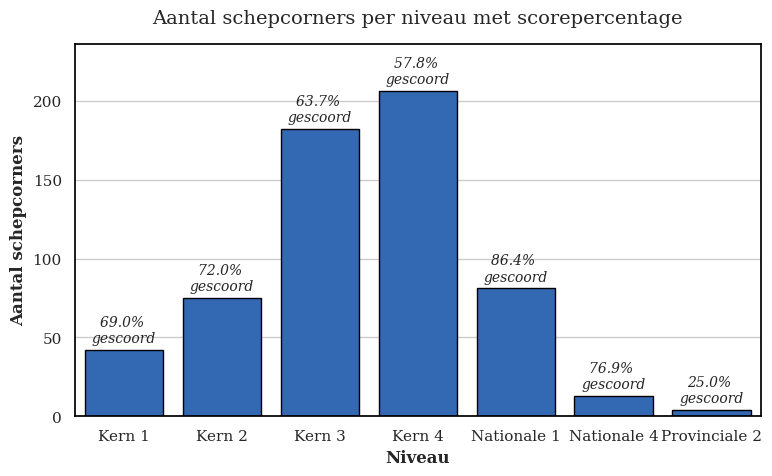

In [67]:
plot_barchart_with_annotations(
    niveau_distributie,
    x_column='niveau',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Niveau',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per niveau met scorepercentage'
)

In [68]:
### percentage per kwart
# aantal schepcorners per kwart
aantal_schepcorners_per_kwart = corners["kwart"].value_counts()

# aantal gescoorde schepcorners per kwart
aantal_gescoord_per_kwart = corners.groupby("kwart")["goal"].sum()

kwart_distributie = pd.DataFrame({
    "aantal_schepcorners": aantal_schepcorners_per_kwart,
    "aantal_gescoord": aantal_gescoord_per_kwart,
    "scorepercentage": aantal_gescoord_per_kwart / aantal_schepcorners_per_kwart * 100
}).reset_index()
kwart_distributie



,kwart,aantal_schepcorners,aantal_gescoord,scorepercentage
0,1,63,47,74.603175
1,2,167,117,70.059880
2,3,206,132,64.077670
3,4,167,103,61.676647


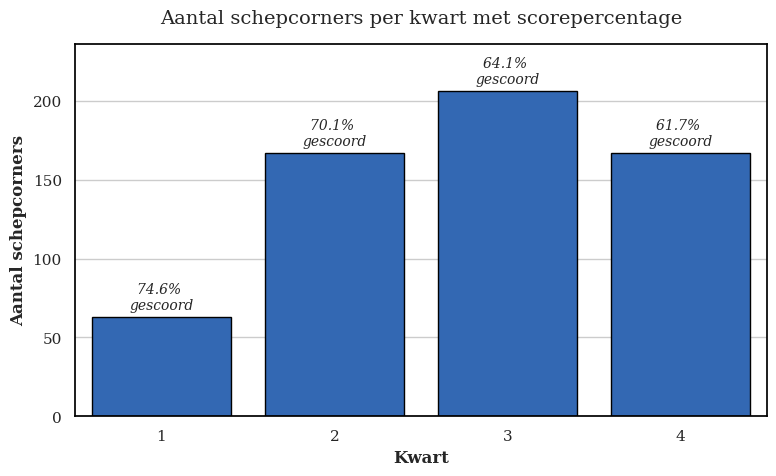

In [69]:
plot_barchart_with_annotations(
    kwart_distributie,
    x_column='kwart',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kwart',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per kwart met scorepercentage'
)

In [70]:
schepper_positie_distributie = calculate_distribution_by_column(corners, "schepper_pos_rechts")
schepper_positie_distributie['schepper_pos_rechts'] = schepper_positie_distributie['schepper_pos_rechts'].replace({1: 'Rechts', 0: 'Links'})
schepper_positie_distributie


,schepper_pos_rechts,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Links,167,109,65.269461
1,Rechts,436,290,66.513761


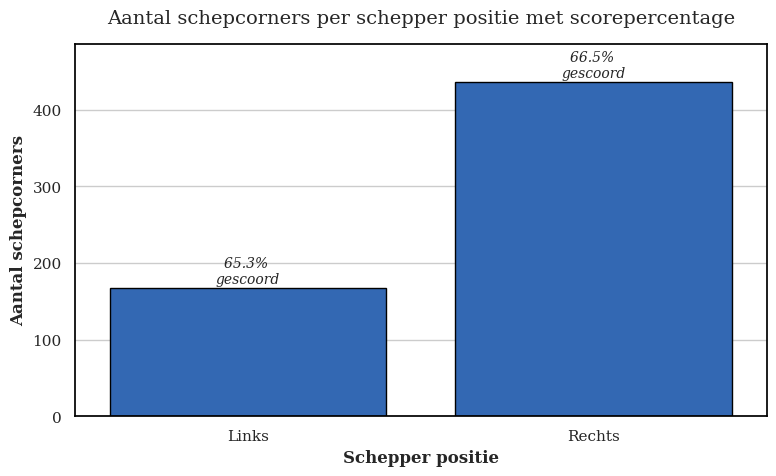

In [71]:
plot_barchart_with_annotations(schepper_positie_distributie,
    x_column='schepper_pos_rechts',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Schepper positie',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per schepper positie met scorepercentage',
    hoogte=50
)

In [72]:
kopper_positie_distributie = calculate_distribution_by_column(corners, "positie")
kopper_positie_distributie['positie'] = kopper_positie_distributie['positie'].replace({1: 'Linksvoor', 2: 'Middenvoor', 3: 'Rechtsvoor', 4: 'Linksachter', 5: 'Middenachter', 6: 'Rechtsachter'})
kopper_positie_distributie

,positie,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Linksvoor,11,6,54.545455
1,Middenvoor,194,134,69.072165
2,Rechtsvoor,17,10,58.823529
3,Linksachter,31,19,61.290323
4,Middenachter,326,213,65.337423
5,Rechtsachter,24,17,70.833333


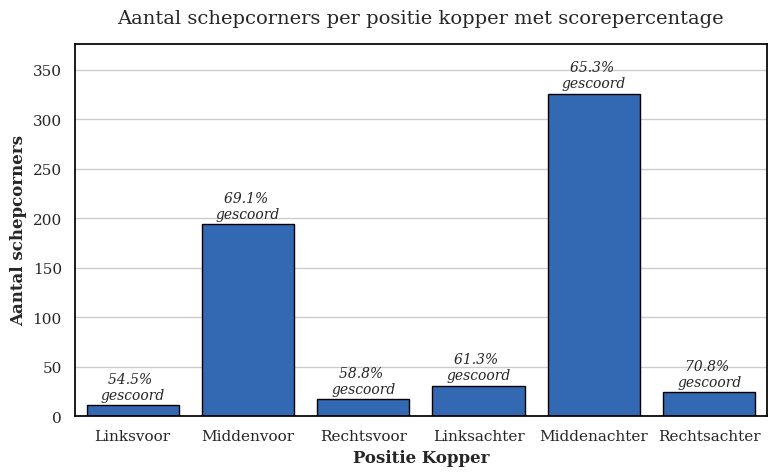

In [73]:
plot_barchart_with_annotations(
    kopper_positie_distributie,
    x_column='positie',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Positie Kopper',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per positie kopper met scorepercentage',
    hoogte=50
)

In [74]:
### nu doen we hetzelfde maar met posities voor en achter en links/midden/rechts
kopper_positie_distributie

,positie,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Linksvoor,11,6,54.545455
1,Middenvoor,194,134,69.072165
2,Rechtsvoor,17,10,58.823529
3,Linksachter,31,19,61.290323
4,Middenachter,326,213,65.337423
5,Rechtsachter,24,17,70.833333


In [75]:
# Definieer de groepen dynamisch
voor_posities = ['Linksvoor', 'Middenvoor', 'Rechtsvoor']  
achter_posities = ['Linksachter', 'Middenachter', 'Rechtsachter'] 

# Bereken de sommen voor voorhoede en achterhoede
voor_posities = kopper_positie_distributie[kopper_positie_distributie['positie'].isin(voor_posities)]
achter_data = kopper_positie_distributie[kopper_positie_distributie['positie'].isin(achter_posities)]

# Sommeer de waarden voor voorhoede en achterhoede
voor_schepcorners = voor_posities['aantal_schepcorners'].sum()
voor_gescoord = voor_posities['aantal_gescoord'].sum()
achter_schepcorners = achter_data['aantal_schepcorners'].sum()
achter_gescoord = achter_data['aantal_gescoord'].sum()

# Bereken de scorepercentages voor elke groep
voor_scorepercentage = (voor_gescoord / voor_schepcorners) * 100 if voor_schepcorners != 0 else 0
achter_scorepercentage = (achter_gescoord / achter_schepcorners) * 100 if achter_schepcorners != 0 else 0

# Maak het resulterende DataFrame dynamisch
kopper_positie_verticaal_distributie = pd.DataFrame({
    "positie": ['Voor', 'Achter'],
    "aantal_schepcorners": [voor_schepcorners, achter_schepcorners],
    "aantal_gescoord": [voor_gescoord, achter_gescoord],
    "scorepercentage": [voor_scorepercentage, achter_scorepercentage]
})

# Toon het resultaat
kopper_positie_verticaal_distributie


,positie,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Voor,222,150,67.567568
1,Achter,381,249,65.354331


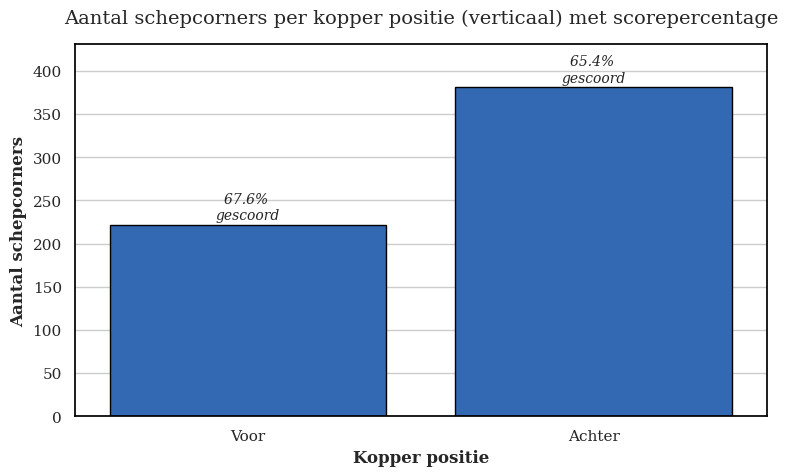

In [76]:
plot_barchart_with_annotations(
    kopper_positie_verticaal_distributie,
    x_column='positie',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kopper positie',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per kopper positie (verticaal) met scorepercentage',
    hoogte=50
)

In [77]:
# Definieer de groepen dynamisch voor links, midden, rechts
links_posities = ['Linksvoor', 'Linksachter']  # Posities voor 'Links'
midden_posities = ['Middenvoor', 'Middenachter']  # Posities voor 'Midden'
rechts_posities = ['Rechtsvoor', 'Rechtsachter']  # Posities voor 'Rechts'

# Bereken de sommen voor Links, Midden en Rechts
links_data = kopper_positie_distributie[kopper_positie_distributie['positie'].isin(links_posities)]
midden_data = kopper_positie_distributie[kopper_positie_distributie['positie'].isin(midden_posities)]
rechts_data = kopper_positie_distributie[kopper_positie_distributie['positie'].isin(rechts_posities)]

# Sommeer de waarden voor Links, Midden en Rechts
links_schepcorners = links_data['aantal_schepcorners'].sum()
links_gescoord = links_data['aantal_gescoord'].sum()
midden_schepcorners = midden_data['aantal_schepcorners'].sum()
midden_gescoord = midden_data['aantal_gescoord'].sum()
rechts_schepcorners = rechts_data['aantal_schepcorners'].sum()
rechts_gescoord = rechts_data['aantal_gescoord'].sum()

# Bereken de scorepercentages voor elke groep
links_scorepercentage = (links_gescoord / links_schepcorners) * 100 if links_schepcorners != 0 else 0
midden_scorepercentage = (midden_gescoord / midden_schepcorners) * 100 if midden_schepcorners != 0 else 0
rechts_scorepercentage = (rechts_gescoord / rechts_schepcorners) * 100 if rechts_schepcorners != 0 else 0

# Maak het resulterende DataFrame dynamisch
kopper_positie_horizontaal_distributie = pd.DataFrame({
    "positie": ['Links', 'Midden', 'Rechts'],
    "aantal_schepcorners": [links_schepcorners, midden_schepcorners, rechts_schepcorners],
    "aantal_gescoord": [links_gescoord, midden_gescoord, rechts_gescoord],
    "scorepercentage": [links_scorepercentage, midden_scorepercentage, rechts_scorepercentage]
})

# Toon het resultaat
kopper_positie_horizontaal_distributie


,positie,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Links,42,25,59.523810
1,Midden,520,347,66.730769
2,Rechts,41,27,65.853659


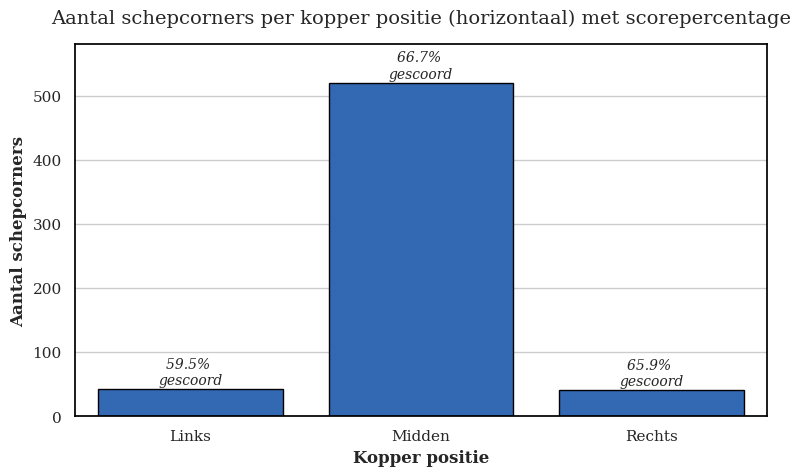

In [78]:
plot_barchart_with_annotations(
    kopper_positie_horizontaal_distributie,
    x_column='positie',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kopper positie',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per kopper positie (horizontaal) met scorepercentage',
    hoogte=60)

### schepkwaliteit
invloed van de schepkwaliteit op de uitkomst van een schepcorner


In [79]:
corners.columns

Index(['schepcorner_id', 'wedstrijd_id', 'ploegnaam', 'ervaring_schepper',
       'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg', 'kwart',
       'is_schepper_bank', 'is_kopper_bank', 'score_voor',
       'schepper_pos_rechts', 'positie', 'kop_verplaatsen_achter',
       'kop_veel_verplaatsen', 'kop_hor_verplaatsen', 'goal'],
      dtype='object')

In [80]:
# te ver naar achter geschept
verplaatsen_achter_distributie = calculate_distribution_by_column(corners, "kop_verplaatsen_achter")
verplaatsen_achter_distributie['kop_verplaatsen_achter'] = verplaatsen_achter_distributie['kop_verplaatsen_achter'].replace({1: 'Ja', 0: 'Nee'})
verplaatsen_achter_distributie

,kop_verplaatsen_achter,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Nee,542,393,72.509225
1,Ja,61,6,9.836066


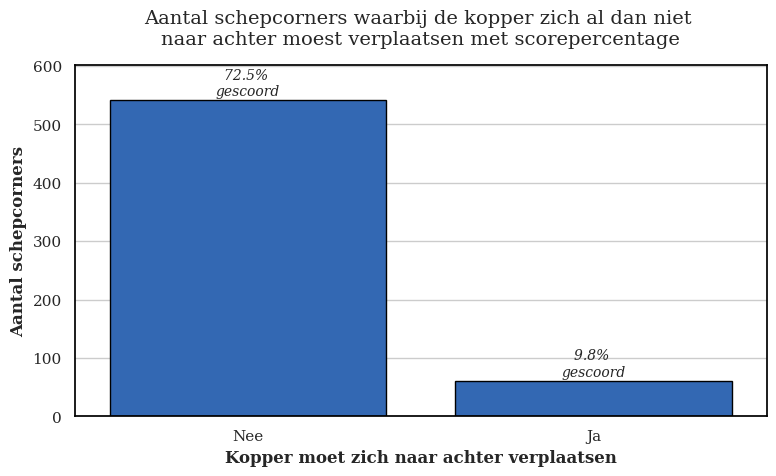

In [81]:
plot_barchart_with_annotations(
    verplaatsen_achter_distributie,
    x_column='kop_verplaatsen_achter',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kopper moet zich naar achter verplaatsen',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners waarbij de kopper zich al dan niet \nnaar achter moest verplaatsen met scorepercentage',
    hoogte=60
)

In [82]:
# horizonaal verplaatsen
verplaatsen_horizontaal_distributie = calculate_distribution_by_column(corners, "kop_hor_verplaatsen")
verplaatsen_horizontaal_distributie['kop_hor_verplaatsen'] = verplaatsen_horizontaal_distributie['kop_hor_verplaatsen'].replace({1: 'Ja', 0: 'Nee'})
verplaatsen_horizontaal_distributie

,kop_hor_verplaatsen,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Nee,467,375,80.299786
1,Ja,136,24,17.647059


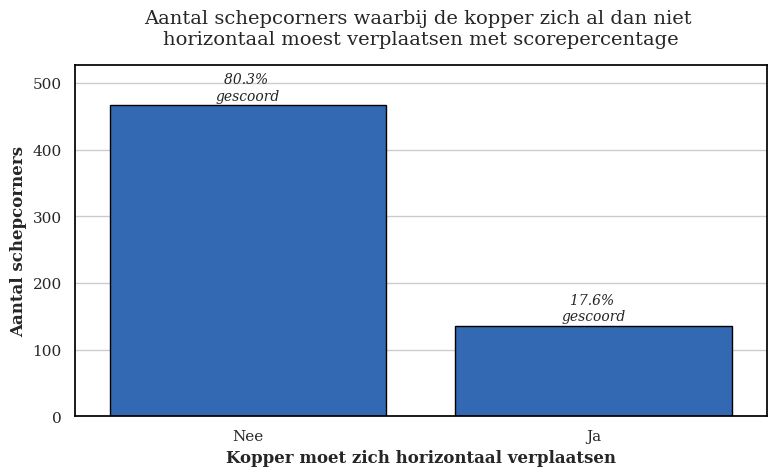

In [83]:
plot_barchart_with_annotations(
    verplaatsen_horizontaal_distributie,
    x_column='kop_hor_verplaatsen',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kopper moet zich horizontaal verplaatsen',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners waarbij de kopper zich al dan niet \nhorizontaal moest verplaatsen met scorepercentage',
    hoogte=60)

In [84]:
# veel verplaatsen
verplaatsen_veel_distributie = calculate_distribution_by_column(corners, "kop_veel_verplaatsen")
verplaatsen_veel_distributie['kop_veel_verplaatsen'] = verplaatsen_veel_distributie['kop_veel_verplaatsen'].replace({1: 'Ja', 0: 'Nee'})
verplaatsen_veel_distributie

,kop_veel_verplaatsen,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Nee,499,389,77.955912
1,Ja,104,10,9.615385


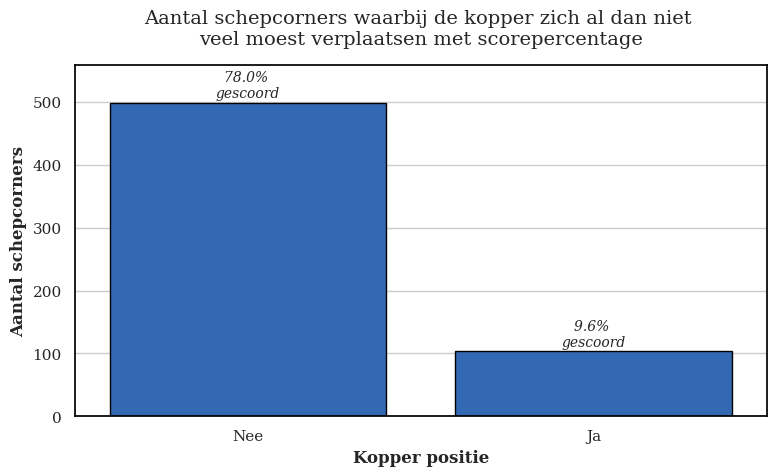

In [85]:
plot_barchart_with_annotations(
    verplaatsen_veel_distributie,
    x_column='kop_veel_verplaatsen',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kopper positie',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners waarbij de kopper zich al dan niet \nveel moest verplaatsen met scorepercentage',
    hoogte=60)

In [86]:
# goed geschept (niet naar achter, horizontaal of veel verplaatsen)
corners["goed_geschept"] = (1-corners["kop_verplaatsen_achter"]) * (1-corners["kop_hor_verplaatsen"]) * (1-corners["kop_veel_verplaatsen"])

In [87]:
goed_geschept_distributie = calculate_distribution_by_column(corners, "goed_geschept")
goed_geschept_distributie['goed_geschept'] = goed_geschept_distributie['goed_geschept'].replace({1: 'Ja', 0: 'Nee'})
goed_geschept_distributie

,goed_geschept,aantal_schepcorners,aantal_gescoord,scorepercentage
0,Nee,191,34,17.801047
1,Ja,412,365,88.592233


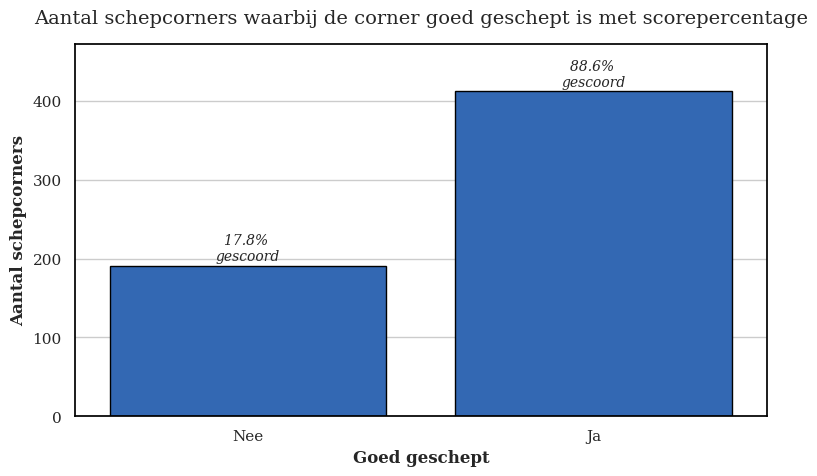

In [88]:
plot_barchart_with_annotations(
    goed_geschept_distributie,
    x_column='goed_geschept',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Goed geschept',
    y_label='Aantal schepcorners', 
    titel='Aantal schepcorners waarbij de corner goed geschept is met scorepercentage',
    hoogte=60
)


In [89]:
### ervaringsniveau
corners["ervaringsniveau"] = round((corners["ervaring_duo"]+corners["ervaring_schepper"]+corners["ervaring_kopper"])/3)
corners["ervaringsniveau"].unique()

array([ 4.,  3.,  2., nan,  1.,  5.])

In [90]:
ervaring_corners = corners[corners["ervaringsniveau"].notna()]

In [91]:
ervaring_corners.head()

,schepcorner_id,wedstrijd_id,ploegnaam,ervaring_schepper,ervaring_kopper,ervaring_duo,is_thuisploeg,kwart,is_schepper_bank,is_kopper_bank,score_voor,schepper_pos_rechts,positie,kop_verplaatsen_achter,kop_veel_verplaatsen,kop_hor_verplaatsen,goal,goed_geschept,ervaringsniveau
0,1,1,marathon,4.0,4.0,4.0,1,1,1,0,0v0,1,5,0,0,0,1,1,4.0
1,2,1,marathon,4.0,4.0,4.0,1,2,0,0,2v0,1,5,0,0,0,0,1,4.0
2,3,1,poba juniors,3.0,2.0,3.0,0,3,0,0,2v0,0,2,0,0,1,0,0,3.0
3,4,2,mvc rudie,4.0,5.0,4.0,1,3,1,0,4v1,1,5,0,1,1,0,0,4.0
4,5,2,uncle abes patty pounders,1.0,5.0,1.0,0,3,1,0,5v2,1,5,0,0,0,0,1,2.0


In [92]:
algemene_ervaring_distributie = calculate_distribution_by_column(ervaring_corners, "ervaringsniveau")
algemene_ervaring_distributie['ervaringsniveau'] = algemene_ervaring_distributie['ervaringsniveau'].astype(int)
algemene_ervaring_distributie

,ervaringsniveau,aantal_schepcorners,aantal_gescoord,scorepercentage
0,1,8,2,25.000000
1,2,42,17,40.476190
2,3,75,45,60.000000
3,4,139,101,72.661871
4,5,158,124,78.481013


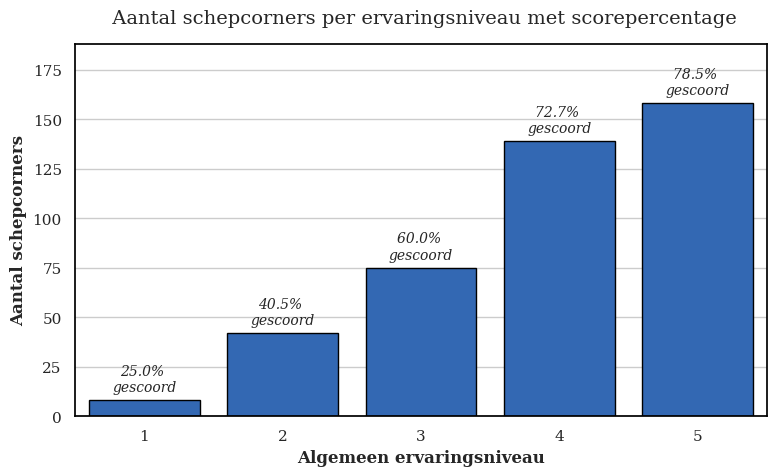

In [93]:
plot_barchart_with_annotations(
    algemene_ervaring_distributie,
    x_column='ervaringsniveau',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Algemeen ervaringsniveau',
    y_label='Aantal schepcorners',
    titel=' Aantal schepcorners per ervaringsniveau met scorepercentage',
)

In [94]:
duo_ervaring_distributie = calculate_distribution_by_column(ervaring_corners, "ervaring_duo")
duo_ervaring_distributie['ervaring_duo'] = duo_ervaring_distributie['ervaring_duo'].astype(int)
duo_ervaring_distributie

,ervaring_duo,aantal_schepcorners,aantal_gescoord,scorepercentage
0,1,32,15,46.875000
1,2,33,16,48.484848
2,3,76,41,53.947368
3,4,119,89,74.789916
4,5,162,128,79.012346


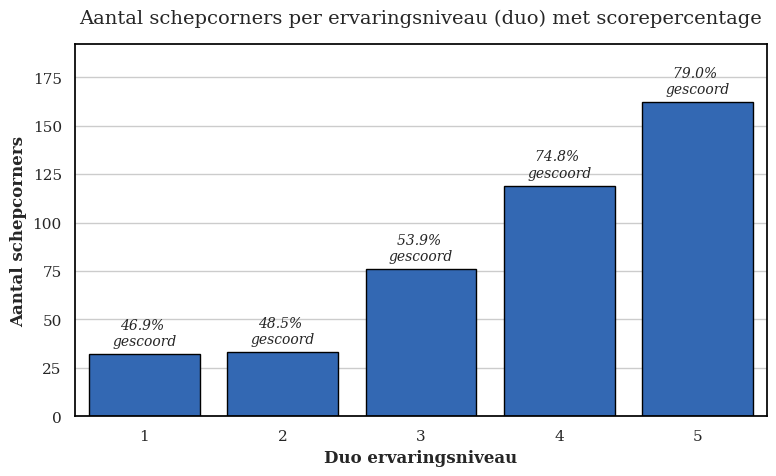

In [95]:
plot_barchart_with_annotations(
    duo_ervaring_distributie,
    x_column='ervaring_duo',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Duo ervaringsniveau',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per ervaringsniveau (duo) met scorepercentage',
    )

In [96]:
kopper_ervaring_distributie = calculate_distribution_by_column(ervaring_corners, "ervaring_kopper")
kopper_ervaring_distributie['ervaring_kopper'] = kopper_ervaring_distributie['ervaring_kopper'].astype(int)
kopper_ervaring_distributie

,ervaring_kopper,aantal_schepcorners,aantal_gescoord,scorepercentage
0,1,17,6,35.294118
1,2,27,8,29.629630
2,3,73,46,63.013699
3,4,127,94,74.015748
4,5,178,135,75.842697


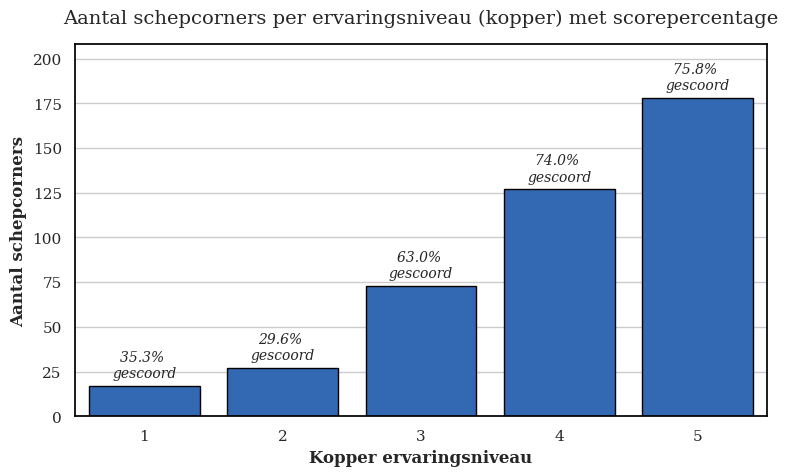

In [97]:
plot_barchart_with_annotations(
    kopper_ervaring_distributie,
    x_column='ervaring_kopper',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kopper ervaringsniveau',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per ervaringsniveau (kopper) met scorepercentage',
    )

In [98]:
schepper_ervaring_distributie = calculate_distribution_by_column(ervaring_corners, "ervaring_schepper")
schepper_ervaring_distributie['ervaring_schepper'] = schepper_ervaring_distributie['ervaring_schepper'].astype(int)
schepper_ervaring_distributie

,ervaring_schepper,aantal_schepcorners,aantal_gescoord,scorepercentage
0,1,15,7,46.666667
1,2,21,5,23.809524
2,3,67,34,50.746269
3,4,149,113,75.838926
4,5,170,130,76.470588


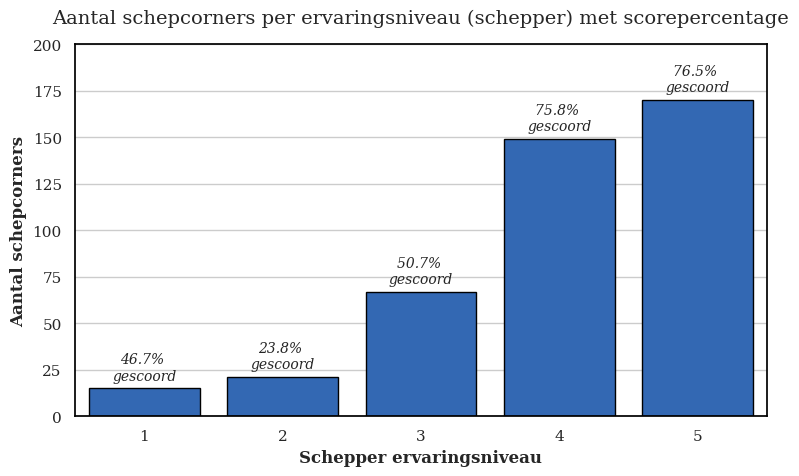

In [99]:
plot_barchart_with_annotations(
    schepper_ervaring_distributie,
    x_column='ervaring_schepper',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Schepper ervaringsniveau',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per ervaringsniveau (schepper) met scorepercentage',
    )

In [100]:
# Armitage trend test voor ervaringsniveau
cochran_armitage_trend_test(
    successes=algemene_ervaring_distributie['aantal_gescoord'].values,
    totals=algemene_ervaring_distributie['aantal_schepcorners'].values,
    alternative='greater'
)

cochran_armitage_trend_test(
    successes=duo_ervaring_distributie['aantal_gescoord'].values,
    totals=duo_ervaring_distributie['aantal_schepcorners'].values,
    alternative='greater'
)

cochran_armitage_trend_test(
    successes=kopper_ervaring_distributie['aantal_gescoord'].values,
    totals=kopper_ervaring_distributie['aantal_schepcorners'].values,
    alternative='greater'
)
cochran_armitage_trend_test(
    successes=schepper_ervaring_distributie['aantal_gescoord'].values,
    totals=schepper_ervaring_distributie['aantal_schepcorners'].values,
    alternative='greater'
)

Z-statistiek: 5.563042707536176
p-waarde: 1.3255548769741665e-08
Z-statistiek: 5.261539948210987
p-waarde: 7.142692104444848e-08
Z-statistiek: 5.231972084355163
p-waarde: 8.385554139955786e-08
Z-statistiek: 5.4510608339842515
p-waarde: 2.5035118755845076e-08


(5.4510608339842515, 2.5035118755845076e-08)

In [101]:
### bank
def bank_verschillen(row):
    if row["is_schepper_bank"] == 1 and row["is_kopper_bank"] == 1:
        return "beide"
    elif row["is_schepper_bank"] == 1 and row["is_kopper_bank"] == 0:
        return "schepper"
    elif row["is_kopper_bank"] == 1 and row["is_schepper_bank"] == 0:
        return "kopper"
    else:
        return "niemand"
    
corners["bank"] = corners.apply(bank_verschillen, axis=1)

In [102]:
bank_distributie = calculate_distribution_by_column(corners, "bank")
bank_distributie


,bank,aantal_schepcorners,aantal_gescoord,scorepercentage
0,beide,2,2,100.000000
1,kopper,65,41,63.076923
2,niemand,449,305,67.928731
3,schepper,87,51,58.620690


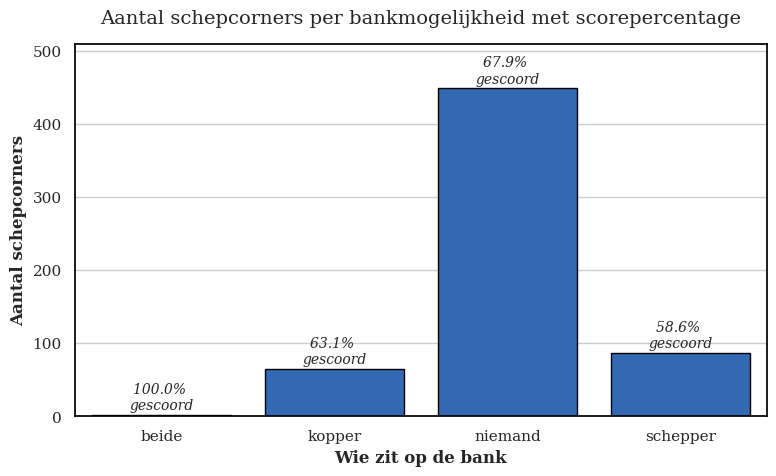

In [103]:
plot_barchart_with_annotations(
    bank_distributie,
    x_column='bank',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Wie zit op de bank',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per bankmogelijkheid met scorepercentage',
    hoogte=60
)

### bekijken per team

In [104]:
merged_df.columns

Index(['wedstrijd_id', 'datum', 'niveau', 'uitslag', 'corners_uitslag',
       'klassement_uitslag', 'schepcorner_id', 'ploegnaam',
       'ervaring_schepper', 'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg',
       'kwart', 'is_schepper_bank', 'is_kopper_bank', 'score_voor',
       'schepper_pos_rechts', 'positie', 'kop_verplaatsen_achter',
       'kop_veel_verplaatsen', 'kop_hor_verplaatsen', 'goal'],
      dtype='object')

In [105]:
team_df = merged_df[["wedstrijd_id", "schepcorner_id", "ploegnaam", "goal"]]

In [106]:
stats_per_team = team_df.groupby("ploegnaam").agg(
    aantal_wedstrijden=("wedstrijd_id", "nunique"),
    aantal_schepcorners=("schepcorner_id", "count"),
    aantal_gescoord=("goal", "sum"),
    scorepercentage=("goal", lambda x: x.sum() / len(x) * 100)
).reset_index()

In [107]:
stats_per_team.sort_values(by="aantal_wedstrijden", ascending=False, inplace=True)

In [108]:
stats_per_team_min_schepcorners = stats_per_team[stats_per_team["aantal_schepcorners"] >= 5]
stats_per_team_min_schepcorners

,ploegnaam,aantal_wedstrijden,aantal_schepcorners,aantal_gescoord,scorepercentage
76,fc spitbulls,20,29,19.0,65.517241
111,marathon,19,38,20.0,52.631579
168,spowerrangers,14,18,10.0,55.555556
183,the oliver boys,11,17,15.0,88.235294
39,de graly's,8,11,6.0,54.545455
185,thomas cook sport,8,10,7.0,70.000000
72,fc dier,7,9,6.0,66.666667
55,drongen,6,13,10.0,76.923077
198,vv int mandje,6,16,10.0,62.500000
65,erwetegem,5,11,10.0,90.909091


### Significanties testen, testen of scoreperc verwachte, uniforme verdeling volgen

In [109]:
def chi_square_test(df, group_col):
    """
    Voert een chi-kwadraat test uit op scorepercentages per groep.

    Args:
        df (pd.DataFrame): DataFrame met kolommen [group_col, aantal_schepcorners, scorepercentage]
        group_col (str): Kolomnaam waarop je wilt groeperen.

    Returns:
        chi2, p_value, degrees_of_freedom, expected (alles uit chi2_contingency)
    """

    # Bereken aantal gescoorde en niet-gescoorde corners
    df = df.copy()
    df['aantal_scores'] = np.round(df['scorepercentage'] / 100 * df['aantal_schepcorners']).astype(int)
    df['aantal_missers'] = df['aantal_schepcorners'] - df['aantal_scores']

    # Maak een kruistabel: rijen = groepen, kolommen = gescoord / niet gescoord
    table = df[[group_col, 'aantal_scores', 'aantal_missers']]
    contingency_table = table.set_index(group_col)

    # Voer chi-kwadraat test uit
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Chi-kwadraat statistiek:", chi2)
    print("Vrijheidsgraden:", dof)
    print("p-waarde:", p_value)

    return chi2, p_value, dof, expected


In [110]:
# niveau
chi2_niveau, p_niveau, dof_niveau, expected_niveau = chi_square_test(niveau_distributie, 'niveau')

Chi-kwadraat statistiek: 26.81101929708377
Vrijheidsgraden: 6
p-waarde: 0.00015709999191823533


In [111]:
# kwart
chi2_kwart, p_kwart, dof_kwart, expected_kwart = chi_square_test(kwart_distributie, 'kwart')

Chi-kwadraat statistiek: 5.039390190855226
Vrijheidsgraden: 3
p-waarde: 0.16893541978406357


In [112]:
kwart_distributie

,kwart,aantal_schepcorners,aantal_gescoord,scorepercentage
0,1,63,47,74.603175
1,2,167,117,70.059880
2,3,206,132,64.077670
3,4,167,103,61.676647


In [113]:
from statsmodels.stats.proportion import proportions_ztest
# Zijn er minder schepcorners in kwart 1 dan verwacht?
# Z-test uitvoeren (alternative='smaller' → specifiek testen of kwart 1 < verwacht)
z_stat, p_value = proportions_ztest(
    count=kwart_distributie['aantal_schepcorners'].values[0],
    nobs=kwart_distributie['aantal_schepcorners'].sum(),
    value=.25,  # Verwachte proportie (25% als alle kwarten gelijk zijn)
    alternative='smaller'
)

print("Z-statistiek:", z_stat)
print("p-waarde:", p_value)


Z-statistiek: -11.68257631200046
p-waarde: 7.823984311275964e-32


In [114]:
# Armitage trend test voor kwart
cochran_armitage_trend_test(
    successes=kwart_distributie['aantal_gescoord'].values,
    totals=kwart_distributie['aantal_schepcorners'].values,
    alternative='less'
)

Z-statistiek: -2.2001802964933606
p-waarde: 0.01389705283715501


(-2.2001802964933606, 0.01389705283715501)

In [115]:
# test om te kijken of aantal schepcorners per kwart significant verschilt
kwart_distributie

observed = kwart_distributie["aantal_schepcorners"].values.tolist()
expected = [kwart_distributie["aantal_schepcorners"].sum() / 4] * 4
chi2, p = chisquare(observed, expected)
print(f"Chi-kwadraat statistiek: {chi2}")   
print(f"p-waarde: {p}")

Chi-kwadraat statistiek: 74.83084577114427
p-waarde: 3.9387668742666937e-16


In [116]:
chi2_schepper_positie, p_schepper_positie, dof_schepper_positie, expected_schepper_positie = chi_square_test(schepper_positie_distributie, 'schepper_pos_rechts')


Chi-kwadraat statistiek: 0.037179530308988046
Vrijheidsgraden: 1
p-waarde: 0.8470999845407083


In [117]:
chi2_kopper_positie, p_kopper_positie, dof_kopper_positie, expected_kopper_positie = chi_square_test(kopper_positie_distributie, 'positie')

Chi-kwadraat statistiek: 2.4676393182955576
Vrijheidsgraden: 5
p-waarde: 0.7813605722143203


In [118]:
chi2_kopper_positie_horizontaal, p_kopper_positie_horizontaal, dof_kopper_positie_horizontaal, expected_kopper_positie_horizontaal = chi_square_test(kopper_positie_horizontaal_distributie, 'positie')


Chi-kwadraat statistiek: 0.9036352985452102
Vrijheidsgraden: 2
p-waarde: 0.6364702199514172


In [119]:
chi2_kopper_positie_verticaal, p_kopper_positie_verticaal, dof_kopper_positie_verticaal, expected_kopper_positie_verticaal = chi_square_test(kopper_positie_verticaal_distributie, 'positie')

Chi-kwadraat statistiek: 0.2160290622168377
Vrijheidsgraden: 1
p-waarde: 0.6420823750443808


In [120]:
chi2_goed_geschept, p_goed_geschept, dof_goed_geschept, expected_goed_geschept = chi_square_test(goed_geschept_distributie, 'goed_geschept')

Chi-kwadraat statistiek: 288.9943969386393
Vrijheidsgraden: 1
p-waarde: 8.235110096591994e-65


In [121]:
chi2_verplaatsen_achter, p_verplaatsen_achter, dof_verplaatsen_achter, expected_verplaatsen_achter = chi_square_test(verplaatsen_achter_distributie, 'kop_verplaatsen_achter')


Chi-kwadraat statistiek: 93.42763053467745
Vrijheidsgraden: 1
p-waarde: 4.2132770067899724e-22


In [122]:
chi2_verplaatsen_horizontaal, p_verplaatsen_horizontaal, dof_verplaatsen_horizontaal, expected_verplaatsen_horizontaal = chi_square_test(verplaatsen_horizontaal_distributie, 'kop_hor_verplaatsen')


Chi-kwadraat statistiek: 181.9046181961616
Vrijheidsgraden: 1
p-waarde: 1.8602731269899268e-41


In [123]:
chi2_verplaatsen_veel, p_verplaatsen_veel, dof_verplaatsen_veel, expected_verplaatsen_veel = chi_square_test(verplaatsen_veel_distributie, 'kop_veel_verplaatsen')

Chi-kwadraat statistiek: 176.51810535291233
Vrijheidsgraden: 1
p-waarde: 2.7906119326640884e-40


In [124]:
chi2_algemene_ervaring, p_algemene_ervaring, dof_algemene_ervaring, expected_algemene_ervaring = chi_square_test(algemene_ervaring_distributie, 'ervaringsniveau')


Chi-kwadraat statistiek: 33.21421890996361
Vrijheidsgraden: 4
p-waarde: 1.079722290633415e-06


In [125]:
chi2_duo_ervaring, p_duo_ervaring, dof_duo_ervaring, expected_duo_ervaring = chi_square_test(duo_ervaring_distributie, 'ervaring_duo')


Chi-kwadraat statistiek: 30.991132746446098
Vrijheidsgraden: 4
p-waarde: 3.0741727014660775e-06


In [126]:
chi2_kopper_ervaring, p_kopper_ervaring, dof_kopper_ervaring, expected_kopper_ervaring = chi_square_test(kopper_ervaring_distributie, 'ervaring_kopper')


Chi-kwadraat statistiek: 34.83982607652762
Vrijheidsgraden: 4
p-waarde: 5.010896907167802e-07


In [127]:
chi2_schepper_ervaring, p_schepper_ervaring, dof_schepper_ervaring, expected_schepper_ervaring = chi_square_test(schepper_ervaring_distributie, 'ervaring_schepper')

Chi-kwadraat statistiek: 41.25145741347747
Vrijheidsgraden: 4
p-waarde: 2.3841335975775112e-08


In [128]:
chi2_bank, p_bank, dof_bank, expected_bank = chi_square_test(bank_distributie, 'bank')

Chi-kwadraat statistiek: 4.135665406783581
Vrijheidsgraden: 3
p-waarde: 0.24718244757158545


### schepkwaliteit per niveau vergelijken

In [129]:
kwaliteit_df = corners[["goed_geschept", "wedstrijd_id", "goal"]].merge(wedstrijden[["wedstrijd_id", "niveau"]], how= "inner")

In [130]:
kwaliteit_df["niveau"] = kwaliteit_df["niveau"].replace({"n1": "nationaal", "n4": "nationaal", 1: "kern_hoog", 2: "kern_hoog", 3: "kern_laag", 4: "kern_laag"})
kwaliteit_df = kwaliteit_df[kwaliteit_df["niveau"] != "p2"]
niveaus_schepkwali_agg = (
    kwaliteit_df.groupby(["niveau", "goed_geschept"])
      .agg(
          aantal_schepcorners = ("goal", "count"),
          aantal_gescoord = ("goal", "sum")
      )
      .reset_index()
)

# Voeg scorepercentage toe
niveaus_schepkwali_agg["scorepercentage"] = (
    niveaus_schepkwali_agg["aantal_gescoord"] / niveaus_schepkwali_agg["aantal_schepcorners"] * 100
)
niveaus_schepkwali_agg["goed_geschept"] = niveaus_schepkwali_agg["goed_geschept"].replace({1: "Ja", 0: "Nee"})
niveaus_schepkwali_agg['percentage_schepcorners_per_niveau'] = (
    niveaus_schepkwali_agg['aantal_schepcorners'] / niveaus_schepkwali_agg.groupby('niveau')['aantal_schepcorners'].transform('sum') * 100
)
print(niveaus_schepkwali_agg)


      niveau goed_geschept  aantal_schepcorners  aantal_gescoord  \
0  kern_hoog           Nee                   29                6   
1  kern_hoog            Ja                   88               77   
2  kern_laag           Nee                  139               21   
3  kern_laag            Ja                  249              214   
4  nationaal           Nee                   21                7   
5  nationaal            Ja                   73               73   

   scorepercentage  percentage_schepcorners_per_niveau  
0        20.689655                           24.786325  
1        87.500000                           75.213675  
2        15.107914                           35.824742  
3        85.943775                           64.175258  
4        33.333333                           22.340426  
5       100.000000                           77.659574  


In [131]:
# Niveauvolgorde definiëren
niveau_order = ["kern_laag", "kern_hoog", "nationaal"]

# Niveaukolom als categorisch definiëren en sorteren
niveaus_schepkwali_agg["niveau"] = pd.Categorical(niveaus_schepkwali_agg["niveau"], categories=niveau_order, ordered=True)
df_sorted = niveaus_schepkwali_agg.sort_values(["niveau", "goed_geschept"]).reset_index(drop=True)


In [132]:
df_sorted

,niveau,goed_geschept,aantal_schepcorners,aantal_gescoord,scorepercentage,percentage_schepcorners_per_niveau
0,kern_laag,Ja,249,214,85.943775,64.175258
1,kern_laag,Nee,139,21,15.107914,35.824742
2,kern_hoog,Ja,88,77,87.500000,75.213675
3,kern_hoog,Nee,29,6,20.689655,24.786325
4,nationaal,Ja,73,73,100.000000,77.659574
5,nationaal,Nee,21,7,33.333333,22.340426


In [133]:
# meer goed geschept naarmate niveau stijgt
cochran_armitage_trend_test(
    successes= [249,88, 73],
    totals= [249+139, 88+29, 73+21], 
    alternative='greater'
)

# goed geschept score perc
cochran_armitage_trend_test(
    successes=[niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Ja"]["aantal_gescoord"].values[1], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Ja"]["aantal_gescoord"].values[0], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Ja"]["aantal_gescoord"].values[2]],
    totals=[niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Ja"]["aantal_schepcorners"].values[1], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Ja"]["aantal_schepcorners"].values[0], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Ja"]["aantal_schepcorners"].values[2]],
    alternative='greater'

)

# slecht geschept score perc
cochran_armitage_trend_test(
    successes=[niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Nee"]["aantal_gescoord"].values[1], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Nee"]["aantal_gescoord"].values[0], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Nee"]["aantal_gescoord"].values[2]],
    totals=[niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Nee"]["aantal_schepcorners"].values[1], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Nee"]["aantal_schepcorners"].values[0], niveaus_schepkwali_agg[niveaus_schepkwali_agg["goed_geschept"] == "Nee"]["aantal_schepcorners"].values[2]],
    alternative='greater'
)

Z-statistiek: 2.9549412081266277
p-waarde: 0.0015636431954318963
Z-statistiek: 3.0786827087740734
p-waarde: 0.0010395899614162873
Z-statistiek: 2.025207119725662
p-waarde: 0.021423050454927095


(2.025207119725662, 0.021423050454927095)

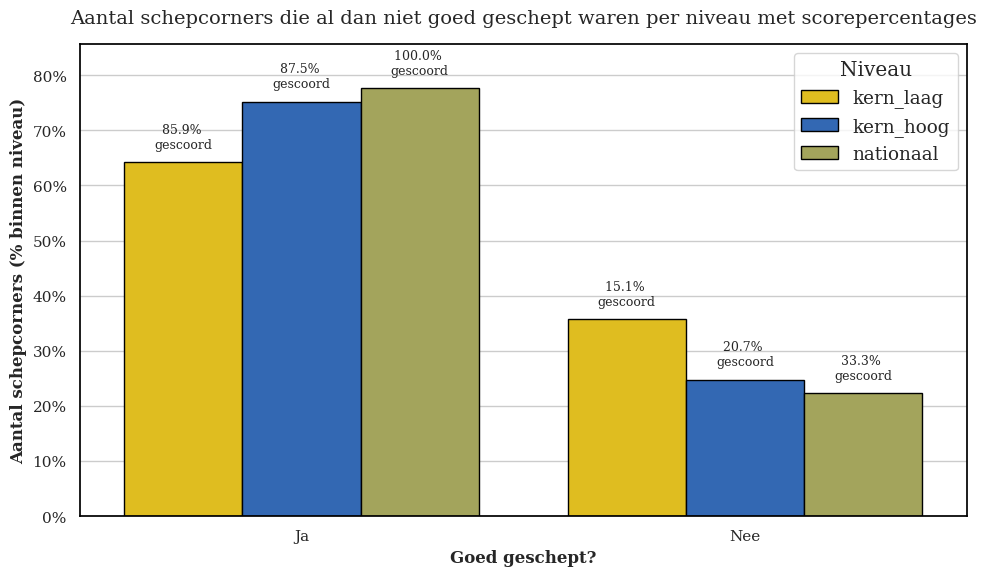

In [134]:
import matplotlib.ticker as mtick
# Niveau-kleurenmapping
kleuren = {
    "kern_hoog": "#1E64C8",   
    "kern_laag": "#FFD200",   
    "nationaal": "#AEB050"    
}

# Plotinstellingen
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })
plt.figure(figsize=(10, 6))

# Barplot met kleur per niveau
ax = sns.barplot(
    data=df_sorted,
    x="goed_geschept",
    y="percentage_schepcorners_per_niveau",
    hue="niveau",
    palette=kleuren,
    edgecolor="black",
    

)

# Annotaties toevoegen op basis van scorepercentage
for bar, (i, row) in zip(ax.patches, df_sorted.iterrows()):
    height = bar.get_height()
    xpos = bar.get_x() + bar.get_width() / 2
    label = f"{row['scorepercentage']:.1f}% \ngescoord"
    ax.text(xpos, height + 2, label, ha='center', va='bottom', fontsize=9)

# Y-as als percentages formatteren
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Titels en labels
y_max = niveaus_schepkwali_agg['percentage_schepcorners_per_niveau'].max()
ax.set_ylim(0, y_max + 8)
plt.title("Aantal schepcorners die al dan niet goed geschept waren per niveau met scorepercentages", pad=15)
plt.xlabel("Goed geschept?", weight="bold")
plt.ylabel("Aantal schepcorners (% binnen niveau)")
plt.legend(title="Niveau")
plt.tight_layout()
plt.show()

### positie per niveau vergelijken

In [135]:
merged_df.columns

Index(['wedstrijd_id', 'datum', 'niveau', 'uitslag', 'corners_uitslag',
       'klassement_uitslag', 'schepcorner_id', 'ploegnaam',
       'ervaring_schepper', 'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg',
       'kwart', 'is_schepper_bank', 'is_kopper_bank', 'score_voor',
       'schepper_pos_rechts', 'positie', 'kop_verplaatsen_achter',
       'kop_veel_verplaatsen', 'kop_hor_verplaatsen', 'goal'],
      dtype='object')

In [136]:
pos_per_niveau_norm = merged_df.groupby("niveau")["positie"].value_counts(normalize=True).unstack().fillna(0)
pos_per_niveau = merged_df.groupby("niveau")["positie"].value_counts().unstack().fillna(0).astype(int)

In [137]:
pos_per_niveau

positie,1.0,2.0,3.0,4.0,5.0,6.0
niveau,,,,,,
1,1,20,0,1,20,0
2,2,14,1,6,49,3
3,6,53,8,9,99,7
4,1,44,3,15,129,14
n1,0,55,5,0,21,0
n4,0,5,0,0,8,0
p2,1,3,0,0,0,0


In [138]:
pos_per_niveau_norm = pos_per_niveau_norm.round(2)
pos_per_niveau_norm

positie,1.0,2.0,3.0,4.0,5.0,6.0
niveau,,,,,,
1,0.02,0.48,0.00,0.02,0.48,0.00
2,0.03,0.19,0.01,0.08,0.65,0.04
3,0.03,0.29,0.04,0.05,0.54,0.04
4,0.00,0.21,0.01,0.07,0.63,0.07
n1,0.00,0.68,0.06,0.00,0.26,0.00
n4,0.00,0.38,0.00,0.00,0.62,0.00
p2,0.25,0.75,0.00,0.00,0.00,0.00


In [139]:
# recreate with three levels, nationaal(n), kern_hoog (1,2), kern_laag (3,4)
niveaus_agg = merged_df.copy()
niveaus_agg["niveau"] = niveaus_agg["niveau"].replace({"n1": "nationaal", "n4": "nationaal", 1: "kern_hoog", 2: "kern_hoog", 3: "kern_laag", 4: "kern_laag"})
niveaus_agg = niveaus_agg[niveaus_agg["niveau"] != "p2"]
pos_per_niveau_agg_norm = niveaus_agg.groupby("niveau")["positie"].value_counts(normalize=True).unstack().fillna(0)
pos_per_niveau_agg = niveaus_agg.groupby("niveau")["positie"].value_counts().unstack().fillna(0).astype(int)
pos_per_niveau_agg_norm = pos_per_niveau_agg_norm.round(2)

In [140]:
pos_per_niveau_agg_norm

positie,1.0,2.0,3.0,4.0,5.0,6.0
niveau,,,,,,
kern_hoog,0.03,0.29,0.01,0.06,0.59,0.03
kern_laag,0.02,0.25,0.03,0.06,0.59,0.05
nationaal,0.00,0.64,0.05,0.00,0.31,0.00


In [141]:
### verschil als we groupen per niveau en positie qua scoringspercentages
niveaus_agg.columns

Index(['wedstrijd_id', 'datum', 'niveau', 'uitslag', 'corners_uitslag',
       'klassement_uitslag', 'schepcorner_id', 'ploegnaam',
       'ervaring_schepper', 'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg',
       'kwart', 'is_schepper_bank', 'is_kopper_bank', 'score_voor',
       'schepper_pos_rechts', 'positie', 'kop_verplaatsen_achter',
       'kop_veel_verplaatsen', 'kop_hor_verplaatsen', 'goal'],
      dtype='object')

In [142]:
niveaus_posities_agg = (
    niveaus_agg.groupby(["niveau", "positie"])
      .agg(
          aantal_schepcorners = ("schepcorner_id", "count"),
          aantal_gescoord = ("goal", "sum")
      )
      .reset_index()
)

# Voeg scorepercentage toe
niveaus_posities_agg["scorepercentage"] = (
    niveaus_posities_agg["aantal_gescoord"] / niveaus_posities_agg["aantal_schepcorners"] * 100
)
niveaus_posities_agg["positie"] = niveaus_posities_agg["positie"].replace({1: "Linksvoor", 2: "Middenvoor", 3: "Rechtsvoor", 4: "Linksachter", 5: "Middenachter", 6: "Rechtsachter"})
print(niveaus_posities_agg)


       niveau       positie  aantal_schepcorners  aantal_gescoord  \
0   kern_hoog     Linksvoor                    3              1.0   
1   kern_hoog    Middenvoor                   34             22.0   
2   kern_hoog    Rechtsvoor                    1              0.0   
3   kern_hoog   Linksachter                    7              5.0   
4   kern_hoog  Middenachter                   69             52.0   
5   kern_hoog  Rechtsachter                    3              3.0   
6   kern_laag     Linksvoor                    7              5.0   
7   kern_laag    Middenvoor                   97             58.0   
8   kern_laag    Rechtsvoor                   11              6.0   
9   kern_laag   Linksachter                   24             14.0   
10  kern_laag  Middenachter                  228            138.0   
11  kern_laag  Rechtsachter                   21             14.0   
12  nationaal    Middenvoor                   60             53.0   
13  nationaal    Rechtsvoor       

In [143]:
# opsplitsen per niveau en plotten
kern_hoog_df = niveaus_posities_agg[niveaus_posities_agg["niveau"] == "kern_hoog"].copy()
kern_laag_df = niveaus_posities_agg[niveaus_posities_agg["niveau"] == "kern_laag"].copy()
nationaal_df = niveaus_posities_agg[niveaus_posities_agg["niveau"] == "nationaal"].copy()

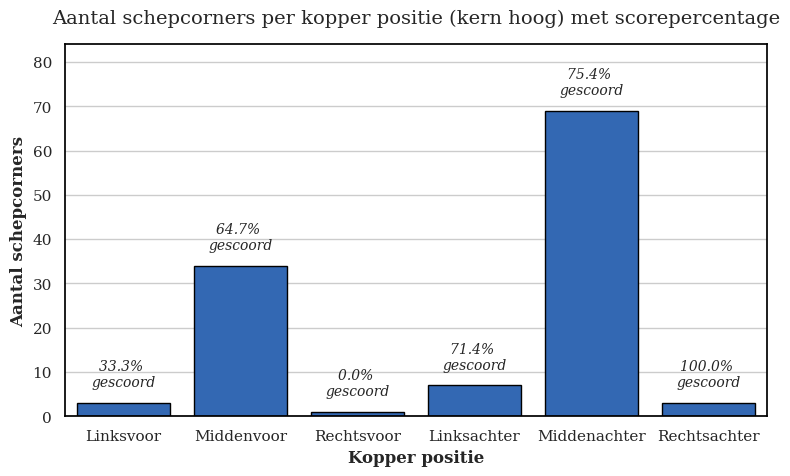

In [144]:
# kern hoog plotten

plot_barchart_with_annotations(
    kern_hoog_df,
    x_column='positie',
    y_column='aantal_schepcorners',
    annotation_column='scorepercentage',
    x_label='Kopper positie',
    y_label='Aantal schepcorners',
    titel='Aantal schepcorners per kopper positie (kern hoog) met scorepercentage',
    hoogte=15
)

In [145]:
kern_laag_df

,niveau,positie,aantal_schepcorners,aantal_gescoord,scorepercentage
6,kern_laag,Linksvoor,7,5.0,71.428571
7,kern_laag,Middenvoor,97,58.0,59.793814
8,kern_laag,Rechtsvoor,11,6.0,54.545455
9,kern_laag,Linksachter,24,14.0,58.333333
10,kern_laag,Middenachter,228,138.0,60.526316
11,kern_laag,Rechtsachter,21,14.0,66.666667


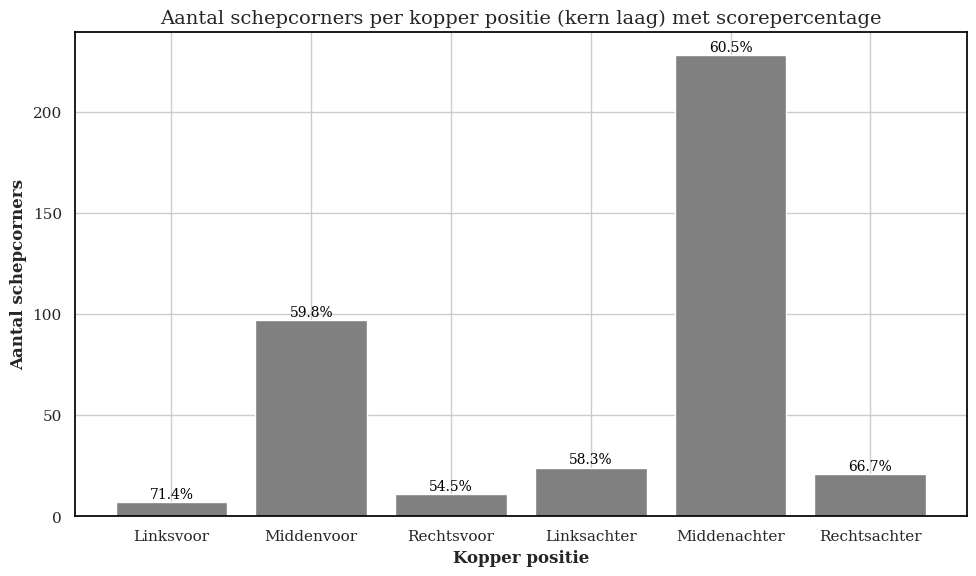

In [146]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(kern_laag_df["positie"], kern_laag_df["aantal_schepcorners"], color='grey')

# Academische stijl instellen
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
    'axes.edgecolor': 'black',
    'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'font.family': 'serif'
    })

# Annotaties toevoegen (scorepercentage)
for bar, percentage in zip(bars, kern_laag_df["scorepercentage"]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontsize=10, color='black')

# Labels en titel
ax.set_xlabel("Kopper positie")
ax.set_ylabel("Aantal schepcorners")
ax.set_title("Aantal schepcorners per kopper positie (kern laag) met scorepercentage")

plt.tight_layout()
plt.show()

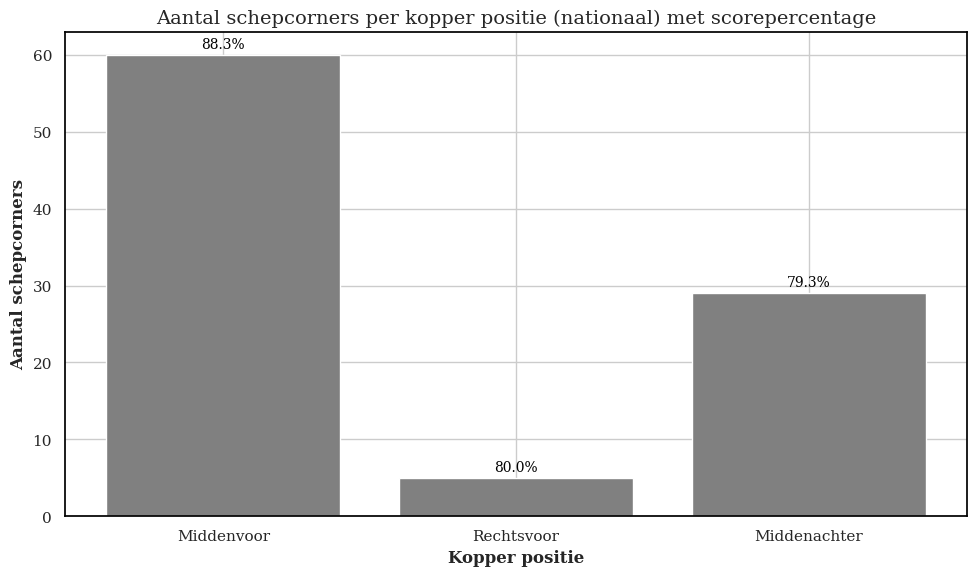

In [147]:

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(nationaal_df["positie"], nationaal_df["aantal_schepcorners"], color='grey')

# Academische stijl instellen
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
    'axes.edgecolor': 'black',
    'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'font.family': 'serif'
    })

# Annotaties toevoegen (scorepercentage)
for bar, percentage in zip(bars, nationaal_df["scorepercentage"]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontsize=10, color='black')

# Labels en titel
ax.set_xlabel("Kopper positie")
ax.set_ylabel("Aantal schepcorners")
ax.set_title("Aantal schepcorners per kopper positie (nationaal) met scorepercentage")

plt.tight_layout()
plt.show()

In [148]:
niveaus_posities_agg['percentage_schepcorners_per_niveau'] = (
    niveaus_posities_agg['aantal_schepcorners'] / niveaus_posities_agg.groupby('niveau')['aantal_schepcorners'].transform('sum') * 100
)


In [149]:
niveaus_posities_agg

,niveau,positie,aantal_schepcorners,aantal_gescoord,scorepercentage,percentage_schepcorners_per_niveau
0,kern_hoog,Linksvoor,3,1.0,33.333333,2.564103
1,kern_hoog,Middenvoor,34,22.0,64.705882,29.059829
2,kern_hoog,Rechtsvoor,1,0.0,0.000000,0.854701
3,kern_hoog,Linksachter,7,5.0,71.428571,5.982906
4,kern_hoog,Middenachter,69,52.0,75.362319,58.974359
5,kern_hoog,Rechtsachter,3,3.0,100.000000,2.564103
6,kern_laag,Linksvoor,7,5.0,71.428571,1.804124
7,kern_laag,Middenvoor,97,58.0,59.793814,25.000000
8,kern_laag,Rechtsvoor,11,6.0,54.545455,2.835052
9,kern_laag,Linksachter,24,14.0,58.333333,6.185567


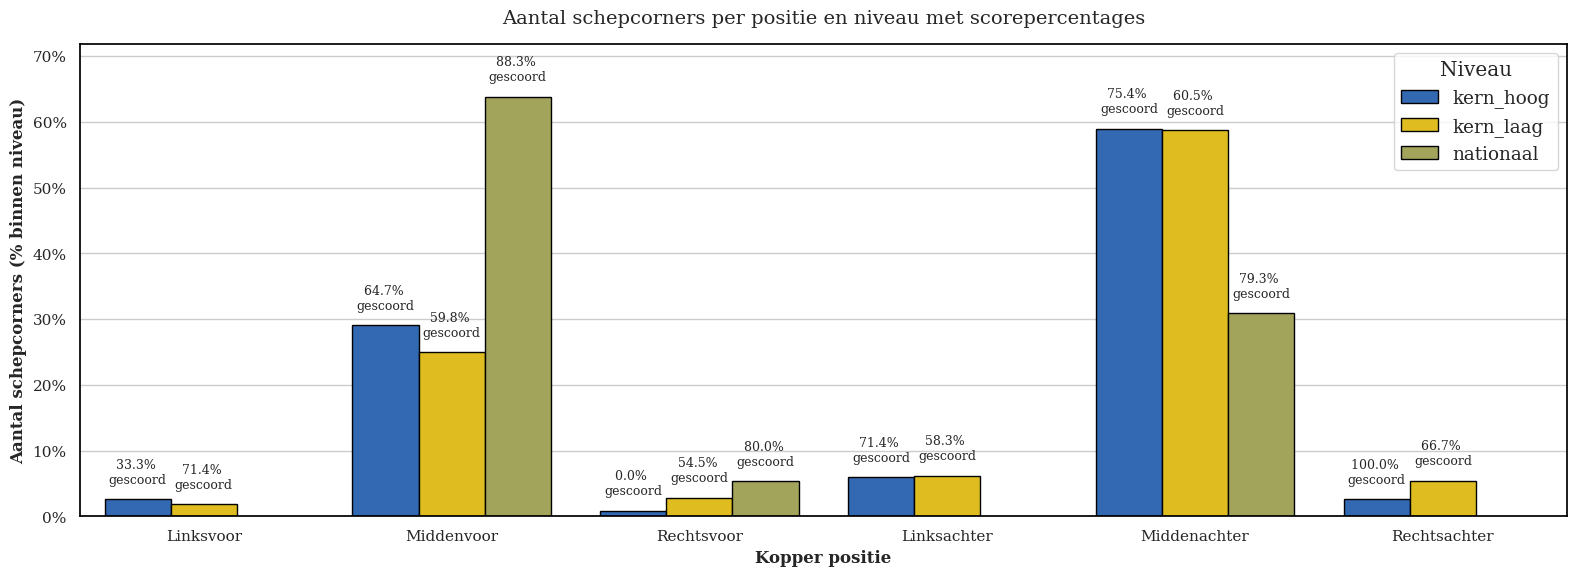

In [150]:

# Niveau-kleurenmapping
kleuren = {
    "kern_hoog": "#1E64C8",   
    "kern_laag": "#FFD200",   
    "nationaal": "#AEB050"    
}

# Plotinstellingen
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })
plt.figure(figsize=(16, 6))

# Barplot met kleur per niveau
ax = sns.barplot(
    data=niveaus_posities_agg,
    x="positie",
    y="percentage_schepcorners_per_niveau",
    hue="niveau",
    palette=kleuren,
    edgecolor="black"
)

# Annotaties toevoegen op basis van scorepercentage
for bar, (i, row) in zip(ax.patches, niveaus_posities_agg.iterrows()):
    height = bar.get_height()
    xpos = bar.get_x() + bar.get_width() / 2
    label = f"{row['scorepercentage']:.1f}% \ngescoord"
    ax.text(xpos, height + 2, label, ha='center', va='bottom', fontsize=9)

# Y-as als percentages formatteren
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Titels en labels
y_max = niveaus_posities_agg['percentage_schepcorners_per_niveau'].max()
ax.set_ylim(0, y_max + 8)
plt.title("Aantal schepcorners per positie en niveau met scorepercentages", pad=15)
plt.xlabel("Kopper positie", weight="bold")
plt.ylabel("Aantal schepcorners (% binnen niveau)")
plt.legend(title="Niveau")
plt.tight_layout()
plt.show()

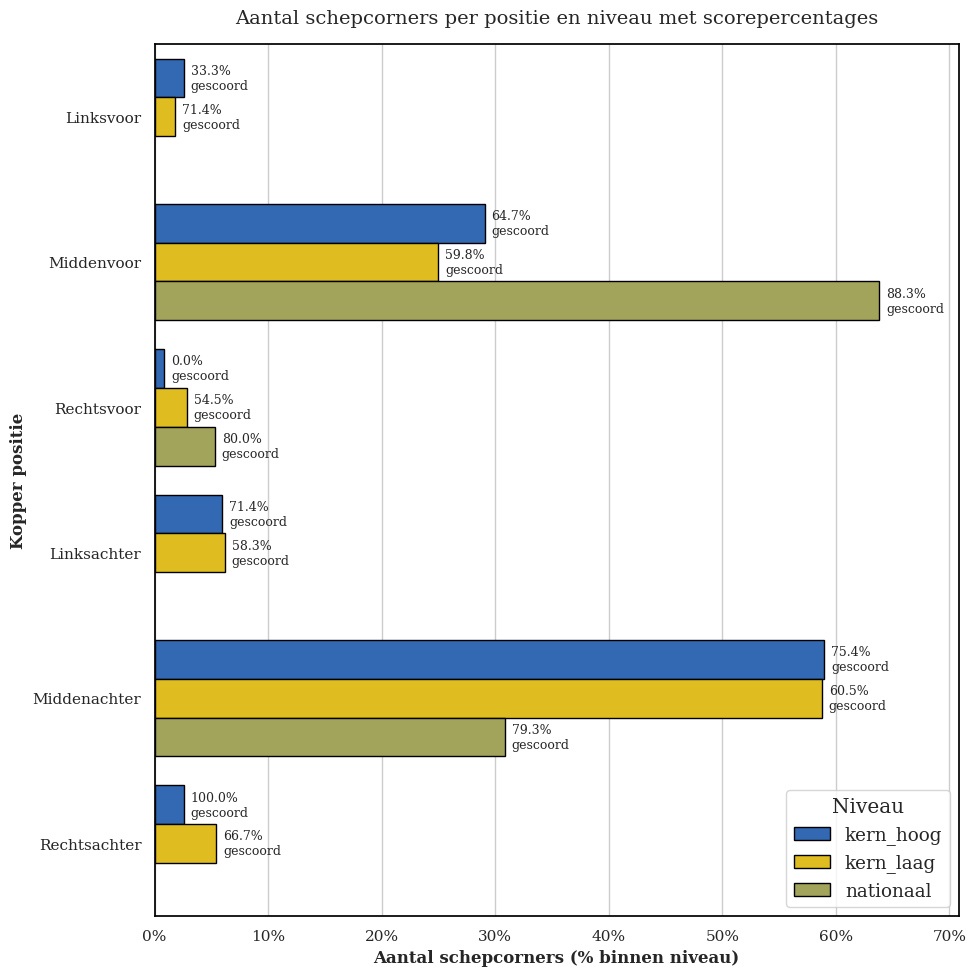

In [151]:
plt.figure(figsize=(10, 10))

# Horizontale barplot
ax = sns.barplot(
    data=niveaus_posities_agg,
    y="positie",  # Y is nu categorisch
    x="percentage_schepcorners_per_niveau",  # X is nu numeriek
    hue="niveau",
    palette=kleuren,
    edgecolor="black",
    dodge=True,
    orient="h",
    width=.8
)

# Annotaties aanpassen (nu op x-positie)
for bar, (i, row) in zip(ax.patches, niveaus_posities_agg.iterrows()):
    width = bar.get_width()
    ypos = bar.get_y() + bar.get_height() / 2
    label = f"{row['scorepercentage']:.1f}%\ngescoord"
    ax.annotate(
        label,
        (width, ypos),
        textcoords="offset points",
        xytext=(5, 0),  # 5 pixels naar rechts
        ha='left',
        va='center',
        fontsize=9
    )

# X-as als percentage formatteren
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Labels en titels
x_max = niveaus_posities_agg['percentage_schepcorners_per_niveau'].max()
ax.set_xlim(0, x_max + 7)
plt.title("Aantal schepcorners per positie en niveau met scorepercentages", pad=15)
plt.ylabel("Kopper positie", weight="bold")
plt.xlabel("Aantal schepcorners (% binnen niveau)")
plt.legend(title="Niveau", loc='lower right')
plt.tight_layout()
plt.show()


In [152]:
# Herclassificeer posities naar 'voor' of 'achter'
voor_posities = ['Linksvoor', 'Middenvoor', 'Rechtsvoor']
achter_posities = ['Linksachter', 'Middenachter', 'Rechtsachter']

niveaus_posities_agg["positie_simpel"] = niveaus_posities_agg["positie"].apply(
    lambda x: "voor" if x in voor_posities else "achter"
)

# Groepeer op niveau en vereenvoudigde positie
geaggregeerd = (
    niveaus_posities_agg
    .groupby(["niveau", "positie_simpel"])
    .agg({
        "aantal_schepcorners": "sum",
        "aantal_gescoord": "sum"
    })
    .reset_index()
)

# Bereken scorepercentage
geaggregeerd["scorepercentage"] = (
    geaggregeerd["aantal_gescoord"] / geaggregeerd["aantal_schepcorners"] * 100
)

# Bereken percentage schepcorners binnen elk niveau
totaal_per_niveau = geaggregeerd.groupby("niveau")["aantal_schepcorners"].transform("sum")
geaggregeerd["percentage_schepcorners_per_niveau"] = (
    geaggregeerd["aantal_schepcorners"] / totaal_per_niveau * 100
)

# Resultaat
geaggregeerd


,niveau,positie_simpel,aantal_schepcorners,aantal_gescoord,scorepercentage,percentage_schepcorners_per_niveau
0,kern_hoog,achter,79,60.0,75.949367,67.521368
1,kern_hoog,voor,38,23.0,60.526316,32.478632
2,kern_laag,achter,273,166.0,60.805861,70.360825
3,kern_laag,voor,115,69.0,60.000000,29.639175
4,nationaal,achter,29,23.0,79.310345,30.851064
5,nationaal,voor,65,57.0,87.692308,69.148936


In [153]:
# Niveauvolgorde definiëren
niveau_order = ["nationaal", "kern_hoog",  "kern_laag"]

# Niveaukolom als categorisch definiëren en sorteren
geaggregeerd["niveau"] = pd.Categorical(geaggregeerd["niveau"], categories=niveau_order, ordered=True)
df_sorted_2 = geaggregeerd.sort_values(["niveau", "positie_simpel"]).reset_index(drop=True)


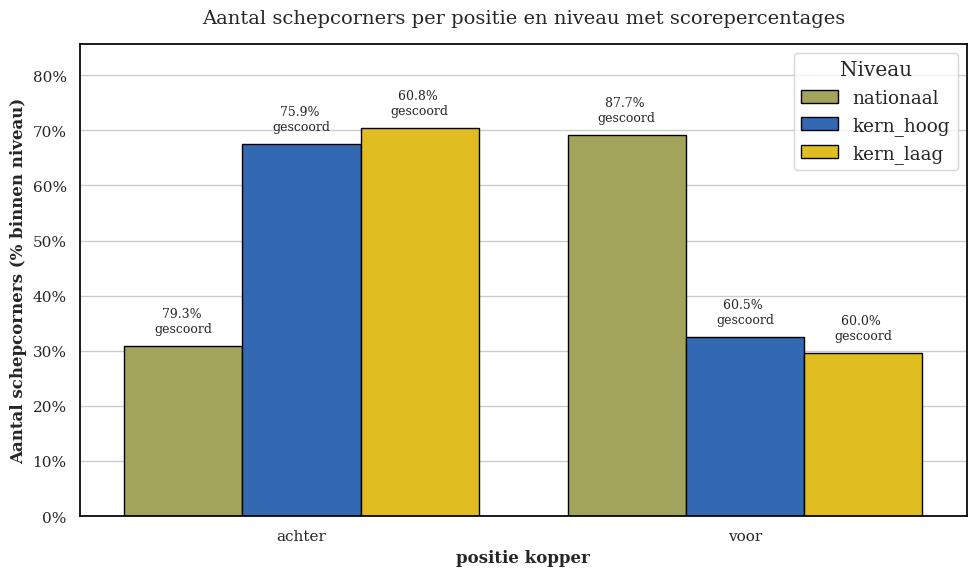

In [154]:

# Niveau-kleurenmapping
kleuren = {
    "kern_hoog": "#1E64C8",   
    "kern_laag": "#FFD200",   
    "nationaal": "#AEB050"    
}

# Plotinstellingen
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })
plt.figure(figsize=(10, 6))

# Barplot met kleur per niveau
ax = sns.barplot(
    data=df_sorted_2,
    x="positie_simpel",
    y="percentage_schepcorners_per_niveau",
    hue="niveau",
    palette=kleuren,
    edgecolor="black",
    

)

# Annotaties toevoegen op basis van scorepercentage
for bar, (i, row) in zip(ax.patches, df_sorted_2.iterrows()):
    height = bar.get_height()
    xpos = bar.get_x() + bar.get_width() / 2
    label = f"{row['scorepercentage']:.1f}% \ngescoord"
    ax.text(xpos, height + 2, label, ha='center', va='bottom', fontsize=9)

# Y-as als percentages formatteren
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Titels en labels
y_max = niveaus_schepkwali_agg['percentage_schepcorners_per_niveau'].max()
ax.set_ylim(0, y_max + 8)
plt.title("Aantal schepcorners per positie en niveau met scorepercentages", pad=15)
plt.xlabel("positie kopper", weight="bold")
plt.ylabel("Aantal schepcorners (% binnen niveau)")
plt.legend(title="Niveau", loc='upper right')
plt.tight_layout()
plt.show()

In [155]:
# Positieverdeling per niveau (voor vs achter)
positie_tabel = np.array([
    [38, 79],    # kern_hoog: [voor, achter]
    [115, 273],  # kern_laag
    [65, 29]     # nationaal
])

# Let op: chi2_contingency verwacht rijen = groepen, kolommen = categorieën
chi2_pos, p_pos, dof_pos, expected_pos = chi2_contingency(positie_tabel)

print("Test 1 - Positieverdeling per niveau (voor vs achter):")
print(f"Chi² = {chi2_pos:.2f}, df = {dof_pos}, p = {p_pos:.4f}")


Test 1 - Positieverdeling per niveau (voor vs achter):
Chi² = 51.99, df = 2, p = 0.0000


In [156]:
# Gegevens: (gescoord, niet gescoord) per niveau en positie
score_data = {
    "kern_hoog": {"voor": (23, 38 - 23), "achter": (60, 79 - 60)},
    "kern_laag": {"voor": (69, 115 - 69), "achter": (166, 273 - 166)},
    "nationaal": {"voor": (57, 65 - 57), "achter": (23, 29 - 23)}
}

print("\nTest 2 - Z-test voor verschil in scoringspercentage (voor vs achter):")
for niveau, posities in score_data.items():
    count = [posities["voor"][0], posities["achter"][0]]  # aantal gescoorde corners
    nobs = [sum(posities["voor"]), sum(posities["achter"])]  # totaal aantal corners
    stat, pval = proportions_ztest(count, nobs)
    print(f"{niveau:<10} - Z = {stat:.2f}, p = {pval:.4f}")



Test 2 - Z-test voor verschil in scoringspercentage (voor vs achter):
kern_hoog  - Z = -1.72, p = 0.0853
kern_laag  - Z = -0.15, p = 0.8821
nationaal  - Z = 1.05, p = 0.2918


In [157]:
### aantal schepcorners voor winnaars versus verliezers versus gelijkspel
# Initialiseer tellers
corners_winnaars = 0
corners_verliezers = 0
corners_gelijkspel = 0
n_gelijkspel = 0

# Per wedstrijd_id de winnaar bepalen
for wedstrijd_id, groep in merged_df.groupby("wedstrijd_id"):
    try:
        # Eindscore parsen
        eind_thuis, eind_uit = map(int, str(groep["uitslag"].iloc[0]).split('v'))
    except:
        continue  # sla over als uitslag niet bruikbaar is

    if eind_thuis == eind_uit:
        corners_gelijkspel += len(groep)
        n_gelijkspel += 1
        continue

    # True = thuis wint, False = uit wint
    thuis_wint = eind_thuis > eind_uit

    # Tel corners op basis van ploeg
    corners_winnaars += (groep["is_thuisploeg"] == thuis_wint).sum()
    corners_verliezers += (groep["is_thuisploeg"] != thuis_wint).sum()

n_geen_gelijkspel = aantal_wedstrijden - n_gelijkspel

# Print resultaat
print(f"Totaal aantal schepcorners door winnaars: {corners_winnaars}")
print(f"Totaal aantal schepcorners door verliezers: {corners_verliezers}")
print(f"Totaal aantal schepcorners bij gelijkspel: {corners_gelijkspel}")
print("-" * 50)
print(f"gemiddeld aantal schepcorners per wedstrijd per ploeg (winnaars): {corners_winnaars / n_geen_gelijkspel:.2f}")
print(f"gemiddeld aantal schepcorners per wedstrijd per ploeg (verliezers): {corners_verliezers / n_geen_gelijkspel:.2f}")
print(f"gemiddeld aantal schepcorners per wedstrijd per ploeg (gelijkspel): {corners_gelijkspel / n_gelijkspel/2:.2f}") # omdat er 2 ploegen gelijkspelen per gelijke match


Totaal aantal schepcorners door winnaars: 304
Totaal aantal schepcorners door verliezers: 236
Totaal aantal schepcorners bij gelijkspel: 64
--------------------------------------------------
gemiddeld aantal schepcorners per wedstrijd per ploeg (winnaars): 1.48
gemiddeld aantal schepcorners per wedstrijd per ploeg (verliezers): 1.15
gemiddeld aantal schepcorners per wedstrijd per ploeg (gelijkspel): 1.23
